In [1]:
import scanpy as sc
import pandas as pd
import bbknn as bbknn

DATA_PATH_23 = 'data/GSE239626/MTX'
DATA_PATH_19 = 'GSE194078'
RANDOM_STATE = 42

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# load reference dataset
adata_ref_GSE239626 = sc.read_10x_mtx(
    DATA_PATH_23,
    var_names='gene_symbols',
    gex_only=True,
    cache=True)

# add cluster labels (assigned by clustering on protein data of reference dataset)
cluster_label_GSE239626 = pd.read_csv('results/cluster_labels.csv', index_col=0)
adata_ref_GSE239626.obs['cluster_label'] = cluster_label_GSE239626

# add cell type labels (on reference dataset)
cell_types_labels = pd.read_csv('results/celltypist_labels_from_protein_Immune_All_High.csv')
adata_ref_GSE239626.obs['cell_types_labels'] = cell_types_labels['predicted_labels'].values

In [3]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'

In [4]:
# new dataset to be integrated with the reference dataset and the cell type labels
adata_GSE194078 = sc.read(DATA_PATH_19) # 9 patients and 2 control: PBMC + CSF cells

In [5]:
sc.pp.normalize_total(adata_ref_GSE239626, target_sum=1e4)
sc.pp.log1p(adata_ref_GSE239626)

In [6]:
sc.pp.normalize_total(adata_GSE194078, target_sum=1e4)
sc.pp.log1p(adata_GSE194078)

In [7]:
sc.tl.pca(
    adata_ref_GSE239626,
    svd_solver='arpack',
    n_comps=30,
    random_state=RANDOM_STATE
    )
sc.pp.neighbors(
    adata_ref_GSE239626,
    n_neighbors=10,
    n_pcs=5,
    knn=True,
    metric='euclidean',
    random_state=RANDOM_STATE
    )

sc.tl.umap(
    adata_ref_GSE239626,
    n_components=2, # number of dimensions of the UMAP embedding
    method='umap',
    random_state=RANDOM_STATE,
    )

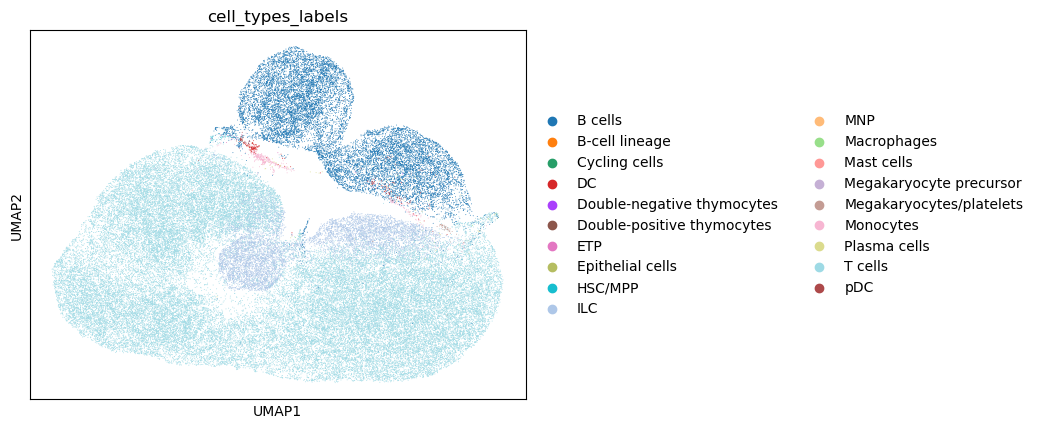

In [8]:
sc.pl.umap(adata_ref_GSE239626, color=['cell_types_labels'])

In [9]:
adata_GSE194078

AnnData object with n_obs × n_vars = 110565 × 36601
    obs: 'patient', 'patient_id', 'disease', 'batch', 'dataset', 'cell_types'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [10]:
adata_ref_GSE239626

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'cluster_label', 'cell_types_labels'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'cell_types_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [11]:
# integrate the new dataset with the reference dataset
sc.tl.ingest(adata_GSE194078, adata_ref_GSE239626, obs='cell_types_labels', random_state=RANDOM_STATE)

c:\Users\giuli\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
# concat the datasets
adata_transcriptomic = adata_ref_GSE239626.concatenate(adata_GSE194078, batch_categories=['reference_GSE239626', 'GSE194078'])

C:\Users\giuli\AppData\Local\Temp\ipykernel_4688\552477359.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_transcriptomic = adata_ref_GSE239626.concatenate(adata_GSE194078, batch_categories=['reference_GSE239626', 'GSE194078'])


In [13]:
adata_transcriptomic.obs.cell_types_labels = adata_transcriptomic.obs.cell_types_labels.astype('category')
adata_transcriptomic.obs.cell_types_labels.cat.reorder_categories(
    adata_ref_GSE239626.obs.cell_types_labels.cat.categories)  # fix category ordering

AAACCCAAGACTGTTC-1-reference_GSE239626    T cells
AAACCCAAGGATCATA-1-reference_GSE239626    T cells
AAACCCAGTTATTCTC-1-reference_GSE239626    B cells
AAACCCATCATGAGGG-1-reference_GSE239626    T cells
AAACGAAAGCCAGTAG-1-reference_GSE239626    B cells
                                           ...   
TTTGGTTGTGTTCAGT-11-CSF-GSE194078         T cells
TTTGGTTTCAAGAAAC-11-CSF-GSE194078         T cells
TTTGTTGGTATACCCA-11-CSF-GSE194078         T cells
TTTGTTGGTTATGACC-11-CSF-GSE194078             ILC
TTTGTTGTCTCCTGTG-11-CSF-GSE194078         T cells
Name: cell_types_labels, Length: 182882, dtype: category
Categories (19, object): ['B cells', 'B-cell lineage', 'Cycling cells', 'DC', ..., 'Monocytes', 'Plasma cells', 'T cells', 'pDC']

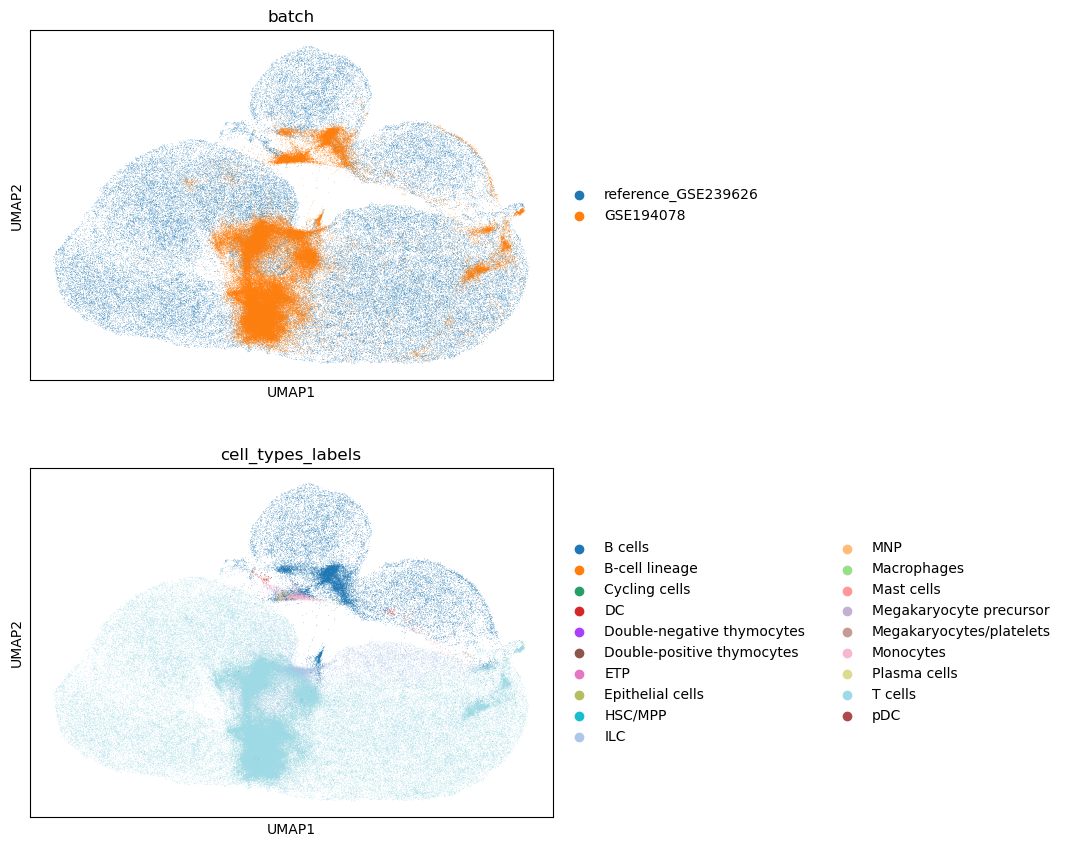

In [14]:
sc.pl.umap(adata_transcriptomic, color=['batch', 'cell_types_labels'], ncols=1)

In [15]:
adata_transcriptomic.obs['batch']

AAACCCAAGACTGTTC-1-reference_GSE239626    reference_GSE239626
AAACCCAAGGATCATA-1-reference_GSE239626    reference_GSE239626
AAACCCAGTTATTCTC-1-reference_GSE239626    reference_GSE239626
AAACCCATCATGAGGG-1-reference_GSE239626    reference_GSE239626
AAACGAAAGCCAGTAG-1-reference_GSE239626    reference_GSE239626
                                                 ...         
TTTGGTTGTGTTCAGT-11-CSF-GSE194078                   GSE194078
TTTGGTTTCAAGAAAC-11-CSF-GSE194078                   GSE194078
TTTGTTGGTATACCCA-11-CSF-GSE194078                   GSE194078
TTTGTTGGTTATGACC-11-CSF-GSE194078                   GSE194078
TTTGTTGTCTCCTGTG-11-CSF-GSE194078                   GSE194078
Name: batch, Length: 182882, dtype: category
Categories (2, object): ['reference_GSE239626', 'GSE194078']

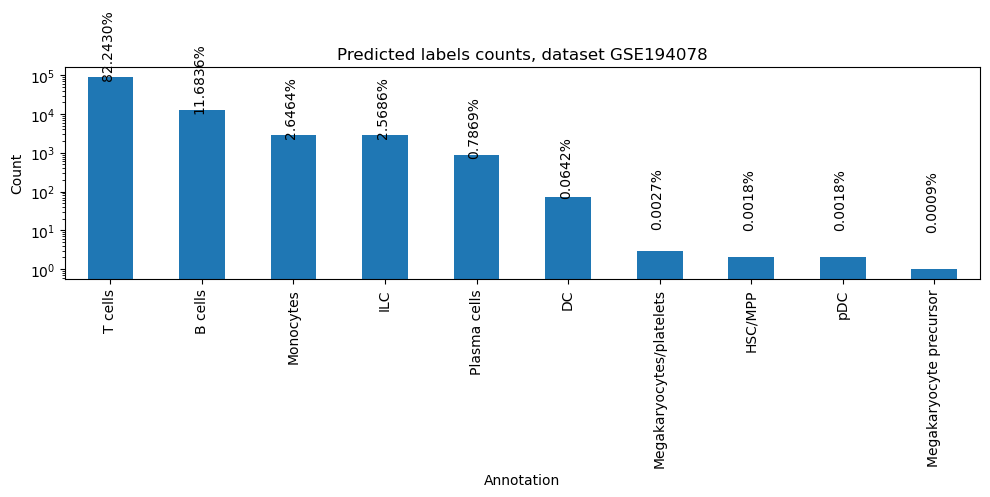

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.gca()
adata_transcriptomic[adata_transcriptomic.obs['batch']=='GSE194078'].obs['cell_types_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata_transcriptomic[adata_transcriptomic.obs['batch']=='GSE194078'].obs['cell_types_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts, dataset GSE194078')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [17]:
sc.tl.pca(adata_transcriptomic)

In [18]:
bbknn.bbknn(adata_transcriptomic, batch_key='batch')

In [19]:
sc.tl.umap(adata_transcriptomic, random_state=RANDOM_STATE)

c:\Users\giuli\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


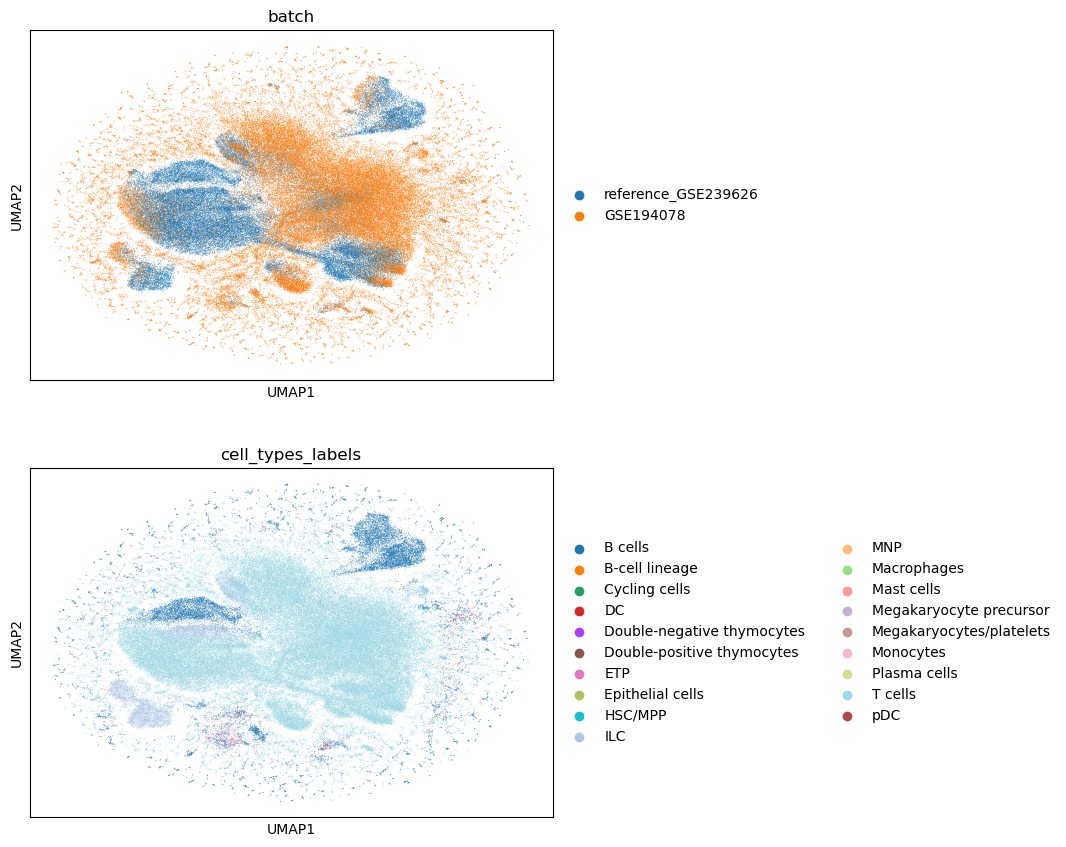

In [20]:
sc.pl.umap(adata_transcriptomic, color=['batch', 'cell_types_labels'], ncols=1)

In [21]:
sc.tl.embedding_density(adata_transcriptomic, groupby='batch')

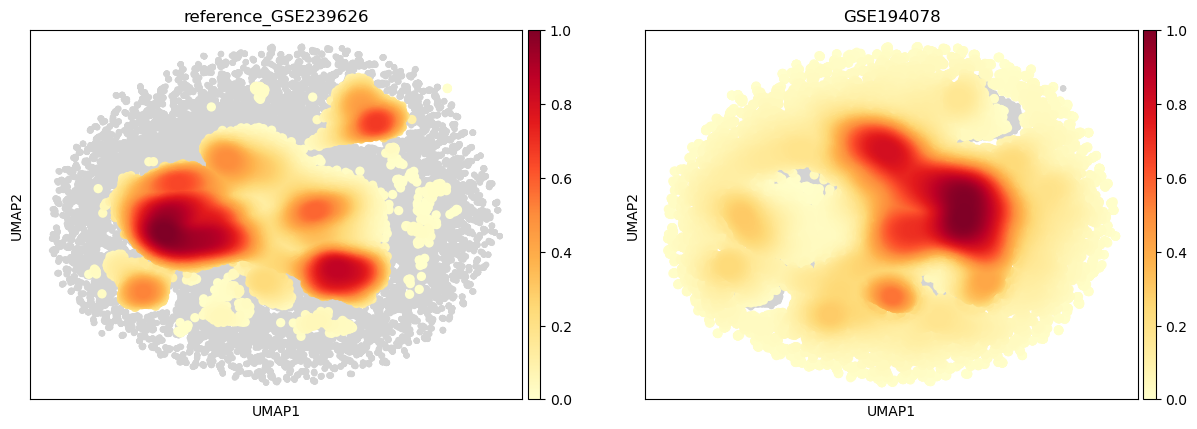

In [22]:
sc.pl.embedding_density(adata_transcriptomic, groupby = 'batch')

In [23]:
# save prediction
predictions = adata_transcriptomic[adata_transcriptomic.obs['batch']=='GSE194078'].obs['cell_types_labels']
predictions.to_csv('results/celltypist_labels_from_transcriptomic_GSE194078.csv')

In [24]:
predictions

AAACCCACAAGACCGA-1-PBMC-GSE194078    B cells
AAACCCACACGGCACT-1-PBMC-GSE194078    T cells
AAACCCATCAGAATAG-1-PBMC-GSE194078    T cells
AAACGAAAGGTAAAGG-1-PBMC-GSE194078    T cells
AAACGAACACAGCCAC-1-PBMC-GSE194078    T cells
                                      ...   
TTTGGTTGTGTTCAGT-11-CSF-GSE194078    T cells
TTTGGTTTCAAGAAAC-11-CSF-GSE194078    T cells
TTTGTTGGTATACCCA-11-CSF-GSE194078    T cells
TTTGTTGGTTATGACC-11-CSF-GSE194078        ILC
TTTGTTGTCTCCTGTG-11-CSF-GSE194078    T cells
Name: cell_types_labels, Length: 110565, dtype: category
Categories (10, object): ['B cells', 'DC', 'HSC/MPP', 'ILC', ..., 'Monocytes', 'Plasma cells', 'T cells', 'pDC']